In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)


# Load the Dataset

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations for data augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Path to your dataset folder
dataset_path = '/kaggle/input/fresh-rotten-and-formalin-mixed-fruit-detection/Fruits Original-ML-GRP-07'

# Load the dataset
train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Create a DataLoader to handle batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Check the number of classes and a sample batch
print(f'Number of classes: {len(train_dataset.classes)}')
print(f'Class names: {train_dataset.classes}')

# Sample batch
for images, labels in train_loader:
    print(f'Images batch shape: {images.shape}')
    print(f'Labels batch shape: {labels.shape}')
    break


Number of classes: 5
Class names: ['Apple', 'Banana', 'Grape', 'Mango', 'Orange']
Images batch shape: torch.Size([32, 3, 128, 128])
Labels batch shape: torch.Size([32])


# Train-Test-Validation

In [11]:
from torch.utils.data import random_split

# Total size
dataset_size = len(train_dataset)

# Split sizes (70/15/15)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Random split
train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Train: 7107
Validation: 1522
Test: 1524


# Dataset Class

In [12]:
from torch.utils.data import Dataset
from PIL import Image

# Custom dataset class for SimCLR
class SimCLRDataset(Dataset):
    def __init__(self, image_folder_dataset, transform=None):
        self.dataset = image_folder_dataset
        self.transform = transform

    def __getitem__(self, index):
        path, target = self.dataset.samples[index]
        image = Image.open(path).convert("RGB")

        if self.transform:
            xi = self.transform(image)
            xj = self.transform(image)
        else:
            xi, xj = image, image

        return xi, xj, target

    def __len__(self):
        return len(self.dataset)


# SimCLR Transforms + Dataloaders

In [13]:
import torchvision.transforms as transforms

# SimCLR Transform (for Pretraining)
class SimCLRTransform:
    def __init__(self, size=128):
        kernel_size = int(0.1 * size)
        # Ensure kernel size is odd
        if kernel_size % 2 == 0:
            kernel_size += 1

        self.transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.GaussianBlur(kernel_size=kernel_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    def __call__(self, x):
        return self.transform(x), self.transform(x)


# Evaluation Transform (for downstream)
eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Apply transforms
simclr_train_dataset = datasets.ImageFolder(root=dataset_path, transform=SimCLRTransform(size=128))
val_dataset.dataset.transform = eval_transform   # overwrite transform for validation
test_dataset.dataset.transform = eval_transform # overwrite transform for test

# Dataloaders
simclr_train_loader = DataLoader(simclr_train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check a batch
for (x1, x2), labels in simclr_train_loader:
    print(f"View1: {x1.shape}, View2: {x2.shape}, Labels: {labels.shape}")
    break

View1: torch.Size([32, 3, 128, 128]), View2: torch.Size([32, 3, 128, 128]), Labels: torch.Size([32])


# SimCLR Model

In [14]:
import torch
import torch.nn as nn
import torchvision.models as models

class SimCLR(nn.Module):
    def __init__(self, base_model="resnet18", out_dim=128):
        super(SimCLR, self).__init__()

        # Encoder (ResNet backbone)
        self.encoder = getattr(models, base_model)(pretrained=False)
        in_features = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()  # remove the classifier head

        # Projection Head
        self.projector = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projector(h)
        return h, z
#Test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLR(base_model="resnet18", out_dim=128).to(device)

# Take a batch from the SimCLR dataloader
(x1, x2), labels = next(iter(simclr_train_loader))
x1, x2 = x1.to(device), x2.to(device)

h1, z1 = model(x1)
h2, z2 = model(x2)

print("h1 shape (features):", h1.shape)
print("z1 shape (projection):", z1.shape)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


h1 shape (features): torch.Size([32, 512])
z1 shape (projection): torch.Size([32, 128])


# Model Training

In [15]:
!pip install lightly

In [17]:
import torch
import torchvision
from torch import nn

from lightly.loss import NTXentLoss
from lightly.models.modules import SimCLRProjectionHead
from lightly.transforms.simclr_transform import SimCLRTransform


class SimCLR(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimCLRProjectionHead(512, 512, 128)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z


resnet = torchvision.models.resnet18()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = SimCLR(backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

transform = SimCLRTransform(input_size=32, gaussian_blur=0.0)
dataset = torchvision.datasets.CIFAR10(
    "datasets/cifar10", download=True, transform=transform
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    num_workers=4,
)

criterion = NTXentLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.06)

print("Starting Training")
for epoch in range(100):
    total_loss = 0
    for batch in dataloader:
        x0, x1 = batch[0]
        x0 = x0.to(device)
        x1 = x1.to(device)
        z0 = model(x0)
        z1 = model(x1)
        loss = criterion(z0, z1)
        total_loss += loss.detach()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(dataloader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

Starting Training
epoch: 00, loss: 5.87910
epoch: 01, loss: 5.67342
epoch: 02, loss: 5.60507
epoch: 03, loss: 5.54329
epoch: 04, loss: 5.51366
epoch: 05, loss: 5.48147
epoch: 06, loss: 5.46141
epoch: 07, loss: 5.44319
epoch: 08, loss: 5.41863
epoch: 09, loss: 5.40183
epoch: 10, loss: 5.39088
epoch: 11, loss: 5.38305
epoch: 12, loss: 5.37458
epoch: 13, loss: 5.35945
epoch: 14, loss: 5.35223
epoch: 15, loss: 5.34409
epoch: 16, loss: 5.33355
epoch: 17, loss: 5.32595
epoch: 18, loss: 5.32447
epoch: 19, loss: 5.31890
epoch: 20, loss: 5.30715
epoch: 21, loss: 5.30397
epoch: 22, loss: 5.29621
epoch: 23, loss: 5.29708
epoch: 24, loss: 5.28376
epoch: 25, loss: 5.28307
epoch: 26, loss: 5.28035
epoch: 27, loss: 5.27488
epoch: 28, loss: 5.27249
epoch: 29, loss: 5.26088
epoch: 30, loss: 5.25916
epoch: 31, loss: 5.25166
epoch: 32, loss: 5.25568
epoch: 33, loss: 5.24785
epoch: 34, loss: 5.24578
epoch: 35, loss: 5.24344
epoch: 36, loss: 5.23320
epoch: 37, loss: 5.23535
epoch: 38, loss: 5.23240
epoch: 

# Cluster Plot

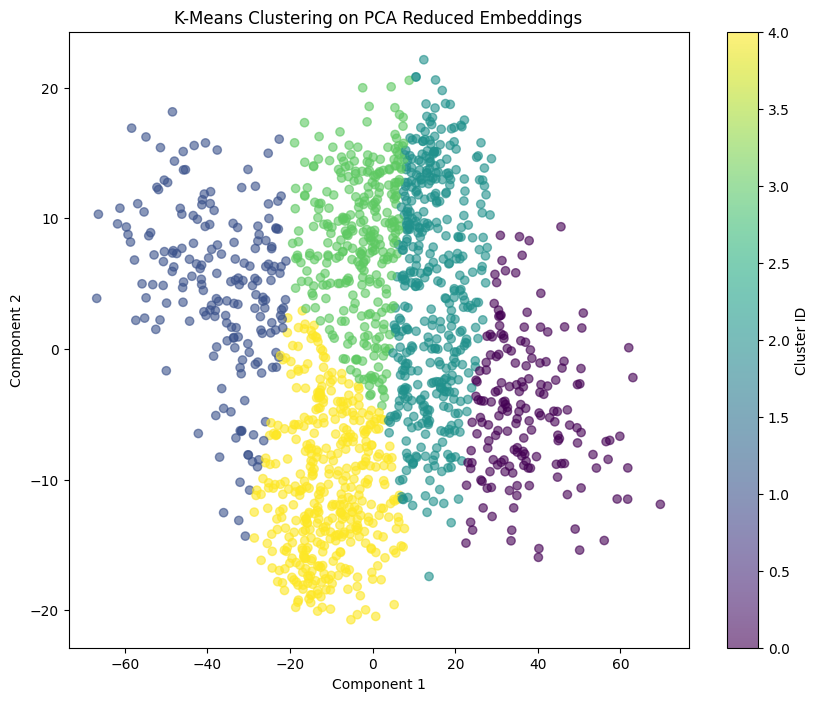

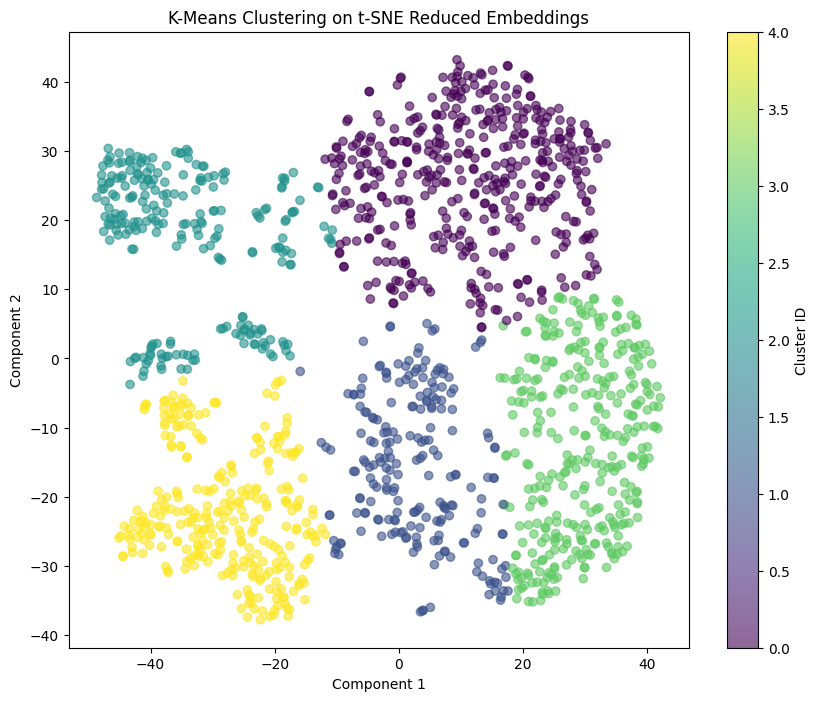

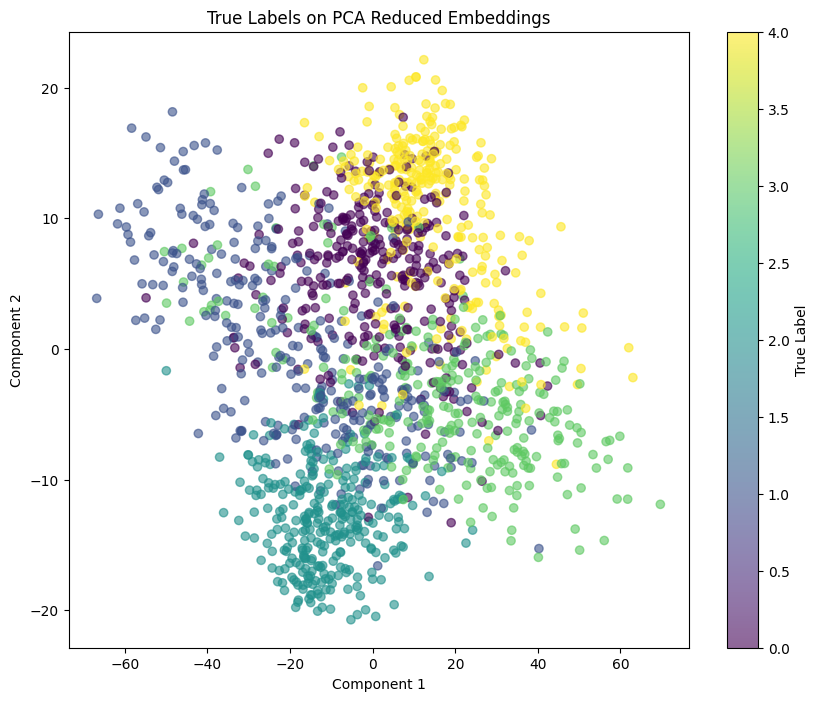

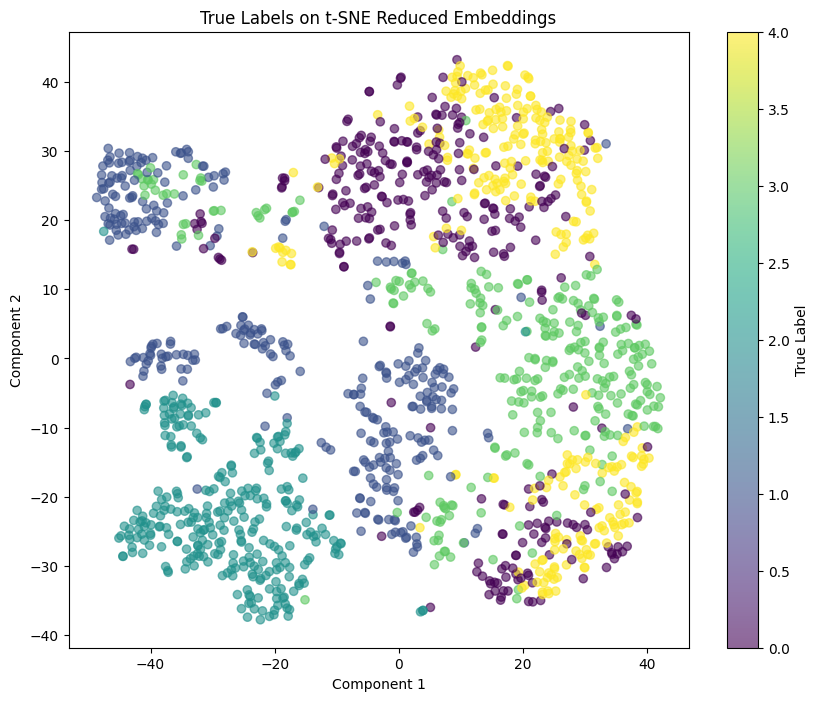

In [20]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np

# Get embeddings from the model
model.eval()
embeddings = []
labels_list = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        h = model.backbone(images).flatten(start_dim=1)
        embeddings.append(h.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

embeddings = np.concatenate(embeddings)
labels_list = np.concatenate(labels_list)

# PCA for dimensionality reduction to 2 components
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# t-SNE for dimensionality reduction to 2 components
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

# K-Means clustering on PCA reduced data
kmeans_pca = KMeans(n_clusters=len(test_dataset.dataset.classes), random_state=42, n_init=10)
clusters_pca = kmeans_pca.fit_predict(embeddings_pca)

# K-Means clustering on t-SNE reduced data
kmeans_tsne = KMeans(n_clusters=len(test_dataset.dataset.classes), random_state=42, n_init=10)
clusters_tsne = kmeans_tsne.fit_predict(embeddings_tsne)


# Plotting function
def plot_clusters(embeddings, clusters, labels, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clusters, cmap='viridis', alpha=0.6)

    # Optional: Add labels for each point
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(scatter, label='Cluster ID')
    plt.show()

# Plot PCA clusters
plot_clusters(embeddings_pca, clusters_pca, labels_list, "K-Means Clustering on PCA Reduced Embeddings")

# Plot t-SNE clusters
plot_clusters(embeddings_tsne, clusters_tsne, labels_list, "K-Means Clustering on t-SNE Reduced Embeddings")

# Plot with true labels for comparison
def plot_true_labels(embeddings, labels, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(scatter, label='True Label')
    plt.show()

plot_true_labels(embeddings_pca, labels_list, "True Labels on PCA Reduced Embeddings")
plot_true_labels(embeddings_tsne, labels_list, "True Labels on t-SNE Reduced Embeddings")

# Extract Embedding

In [22]:
# Extract Embeddings and Labels
model.eval()
embeddings = []
labels_list = []

with torch.no_grad():  # Disable gradient calculation for inference
    for images, labels in test_loader:
        images = images.to(device)
        # Get the features (h) from the backbone
        h = model.backbone(images).flatten(start_dim=1)
        embeddings.append(h.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

embeddings = np.concatenate(embeddings)
labels_list = np.concatenate(labels_list)

print(f"Extracted embeddings shape: {embeddings.shape}")
print(f"Extracted labels shape: {labels_list.shape}")


Extracted embeddings shape: (1524, 512)
Extracted labels shape: (1524,)


# Design Downstream Classifier

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import numpy as np

n_clusters = len(np.unique(labels_list))
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
predicted_clusters = kmeans.fit_predict(embeddings)

print(f"Number of clusters: {n_clusters}")
print(f"Shape of predicted clusters: {predicted_clusters.shape}")

# Evaluate the clustering performance
ari = adjusted_rand_score(labels_list, predicted_clusters)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Normalized
nmi = normalized_mutual_info_score(labels_list, predicted_clusters)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")


Number of clusters: 5
Shape of predicted clusters: (1524,)
Adjusted Rand Index (ARI): 0.2710
Normalized Mutual Information (NMI): 0.3136


# Transform + Dataloader for Downstream

In [26]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset

downstream_train_transform = transforms.Compose([
])
downstream_eval_transform = transforms.Compose([
    # Removed ToTensor()
    transforms.Resize(256),
    transforms.CenterCrop(224),
    ])
# redefine DownstreamDataset to get PIL Image first, then apply transforms
class DownstreamDataset(TorchDataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        # Get the original dataset from the subset
        self.original_dataset = subset.dataset
        self.indices = subset.indices
        self.transform = transform

    def __getitem__(self, index):
        # Get the original index in the full dataset
        original_index = self.indices[index]
        path, target = self.original_dataset.samples[original_index]
        image = Image.open(path).convert("RGB")

        if self.transform:
            x = self.transform(image)
        else:
            x = image

        return x, target

    def __len__(self):
        return len(self.subset)

from PIL import Image

# Redefine the transforms to include ToTensor() and expect PIL Image input
downstream_train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

downstream_eval_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Apply the downstream transforms to the existing subsets using the corrected class
downstream_train_dataset = DownstreamDataset(train_dataset, transform=downstream_train_transform)
downstream_val_dataset = DownstreamDataset(val_dataset, transform=downstream_eval_transform)
downstream_test_dataset = DownstreamDataset(test_dataset, transform=downstream_eval_transform)


# Create DataLoaders for the downstream task
downstream_train_loader = DataLoader(downstream_train_dataset, batch_size=32, shuffle=True, num_workers=2)
downstream_val_loader = DataLoader(downstream_val_dataset, batch_size=32, shuffle=False, num_workers=2)
downstream_test_loader = DataLoader(downstream_test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Downstream DataLoaders created.")
print(f"Number of batches in train_loader: {len(downstream_train_loader)}")
print(f"Number of batches in val_loader: {len(downstream_val_loader)}")
print(f"Number of batches in test_loader: {len(downstream_test_loader)}")

# Check a batch from the train loader
for images, labels in downstream_train_loader:
    print(f'Images batch shape (downstream): {images.shape}')
    print(f'Labels batch shape (downstream): {labels.shape}')
    break

Downstream DataLoaders created.
Number of batches in train_loader: 223
Number of batches in val_loader: 48
Number of batches in test_loader: 48
Images batch shape (downstream): torch.Size([32, 3, 224, 224])
Labels batch shape (downstream): torch.Size([32])


# Downstream Training

Starting Downstream Training
Epoch [1/100], Loss: 1.2478
Epoch [2/100], Loss: 1.0083
Epoch [3/100], Loss: 0.9211
Epoch [4/100], Loss: 0.8795
Epoch [5/100], Loss: 0.8317
Epoch [6/100], Loss: 0.7926
Epoch [7/100], Loss: 0.7720
Epoch [8/100], Loss: 0.7508
Epoch [9/100], Loss: 0.7254
Epoch [10/100], Loss: 0.7135
Epoch [11/100], Loss: 0.6957
Epoch [12/100], Loss: 0.6929
Epoch [13/100], Loss: 0.6671
Epoch [14/100], Loss: 0.6749
Epoch [15/100], Loss: 0.6580
Epoch [16/100], Loss: 0.6515
Epoch [17/100], Loss: 0.6410
Epoch [18/100], Loss: 0.6295
Epoch [19/100], Loss: 0.6212
Epoch [20/100], Loss: 0.6200
Epoch [21/100], Loss: 0.6157
Epoch [22/100], Loss: 0.6021
Epoch [23/100], Loss: 0.6043
Epoch [24/100], Loss: 0.5865
Epoch [25/100], Loss: 0.5996
Epoch [27/100], Loss: 0.5886
Epoch [28/100], Loss: 0.5879
Epoch [29/100], Loss: 0.5720
Epoch [30/100], Loss: 0.5632
Epoch [31/100], Loss: 0.5632
Epoch [32/100], Loss: 0.5626
Epoch [33/100], Loss: 0.5620
Epoch [34/100], Loss: 0.5625
Epoch [35/100], Loss: 0

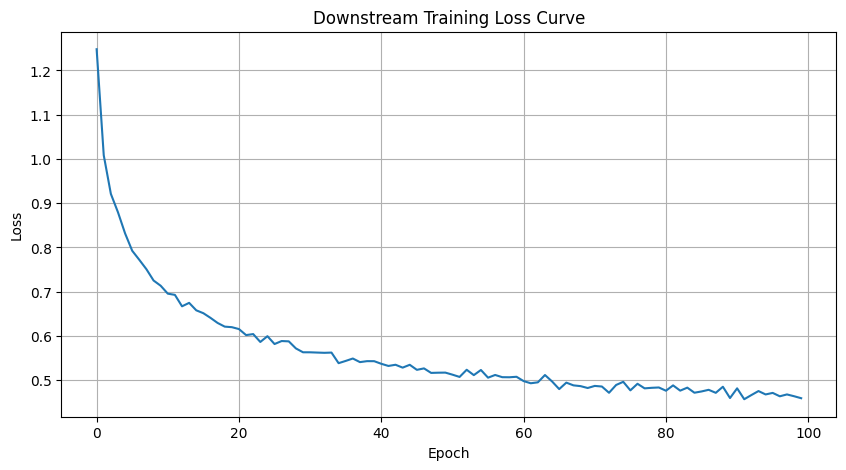

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt

# Define a simple downstream classifier
class DownstreamClassifier(nn.Module):
    def __init__(self, backbone, num_classes):
        super(DownstreamClassifier, self).__init__()
        self.backbone = backbone
        # Freeze the backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Add a linear layer for classification
        backbone_output_size = 512
        self.fc = nn.Linear(backbone_output_size, num_classes)

    def forward(self, x):
        with torch.no_grad():  # Ensure backbone is not trained
            features = self.backbone(x).flatten(start_dim=1)
        output = self.fc(features)
        return output


if __name__ == "__main__":   # Important for Kaggle to avoid multiprocessing error
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate the downstream classifier
    num_classes = len(downstream_train_dataset.subset.dataset.classes)
    downstream_model = DownstreamClassifier(model.backbone, num_classes).to(device)

    # Combine train and validation datasets
    combined_train_val_dataset = ConcatDataset([downstream_train_dataset, downstream_val_dataset])
    combined_train_val_loader = DataLoader(
        combined_train_val_dataset,
        batch_size=32,
        shuffle=True,
        num_workers=2,   # Kaggle can handle multiprocessing
        pin_memory=True  # helps when using GPU
    )

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(downstream_model.fc.parameters(), lr=0.001)

    # Training loop
    num_epochs = 100
    loss_history = []

    print("Starting Downstream Training")
    for epoch in range(num_epochs):
        downstream_model.train()
        running_loss = 0.0
        for images, labels in combined_train_val_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # Forward pass
            outputs = downstream_model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(combined_train_val_dataset)
        loss_history.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    print("Downstream Training Finished")

    # Plot the loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title('Downstream Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()


#  Evaluation (on Test set)

Overall Accuracy: 0.9619

Class Accuracy:
  Apple: 0.9263 (289/312)
  Banana: 0.9905 (313/316)
  Grape: 0.9934 (303/305)
  Mango: 0.9550 (276/289)
  Orange: 0.9437 (285/302)

Classification Report:
              precision    recall  f1-score   support

       Apple       0.96      0.93      0.94       312
      Banana       0.97      0.99      0.98       316
       Grape       1.00      0.99      1.00       305
       Mango       0.93      0.96      0.94       289
      Orange       0.95      0.94      0.95       302

    accuracy                           0.96      1524
   macro avg       0.96      0.96      0.96      1524
weighted avg       0.96      0.96      0.96      1524


Confusion Matrix:


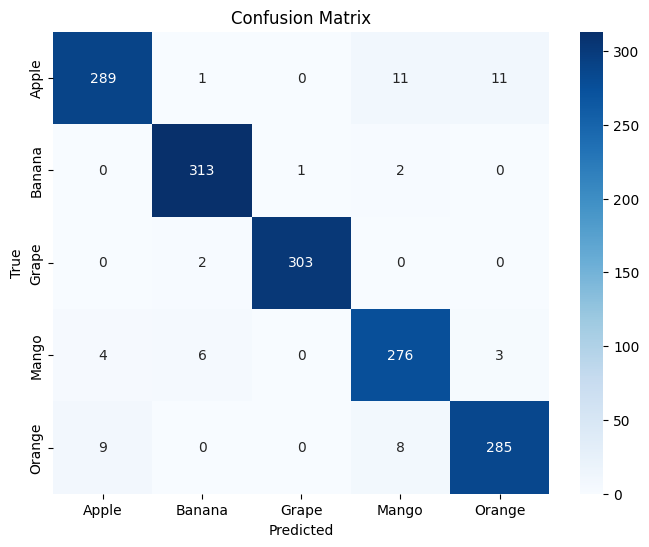

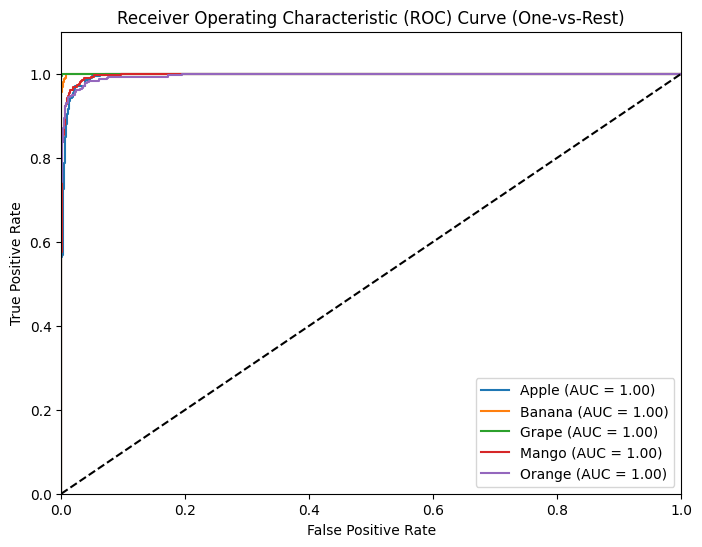

In [78]:
import torch
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch.nn.functional as F

# Set the model to evaluation mode
downstream_model.eval()

all_labels = []
all_predictions = []
all_probs = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for images, labels in downstream_test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = downstream_model(images)
        probabilities = F.softmax(outputs, dim=1) 
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)
all_probs = np.array(all_probs)

# 1. Class accuracy (per class & overall)
correct = (all_predictions == all_labels).sum()
total = len(all_labels)
overall_accuracy = correct / total
print(f'Overall Accuracy: {overall_accuracy:.4f}')

class_correct = {}
class_total = {}
for label in np.unique(all_labels):
    class_correct[label] = ((all_predictions == label) & (all_labels == label)).sum()
    class_total[label] = (all_labels == label).sum()

print('\nClass Accuracy:')
for label, correct_count in class_correct.items():
    accuracy = correct_count / class_total[label] if class_total[label] > 0 else 0
    class_name = downstream_test_dataset.subset.dataset.classes[label]
    print(f'  {class_name}: {accuracy:.4f} ({correct_count}/{class_total[label]})')

# 2. Classification report
print('\nClassification Report:')
class_names = [downstream_test_dataset.subset.dataset.classes[i] for i in sorted(np.unique(all_labels))]
print(classification_report(all_labels, all_predictions, target_names=class_names))

# 3. Confusion matrix
print('\nConfusion Matrix:')
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 4. ROC / AUC 
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels == i, all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()

# Gard-CAM

In [80]:
# Install the necessary library for Grad-CAM
!pip install grad-cam

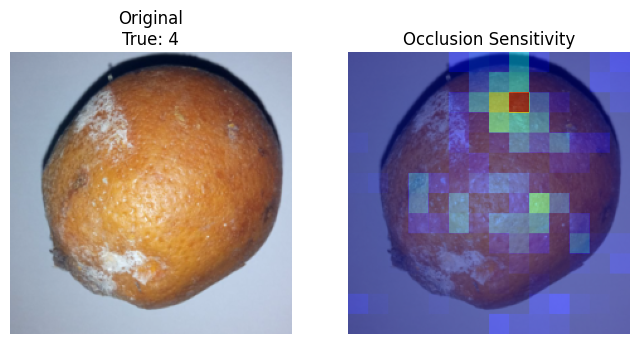

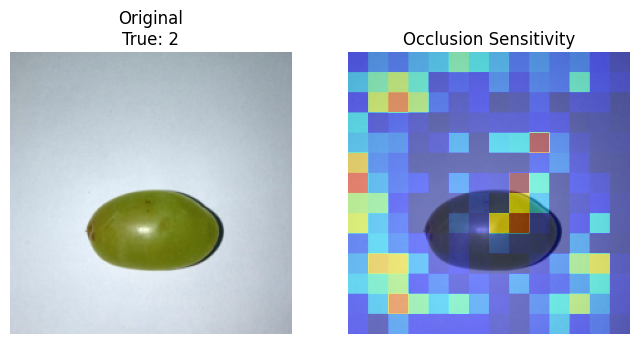

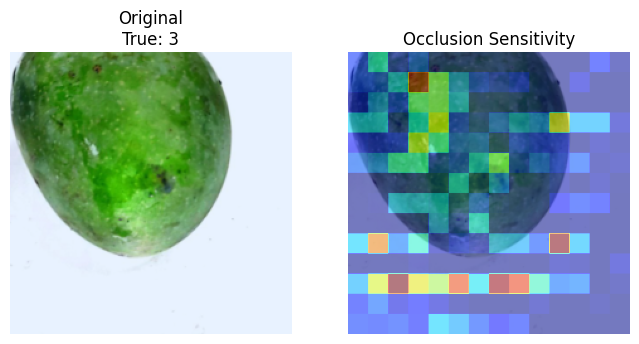

In [90]:
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
downstream_model.eval()
downstream_model.to(device)

# Parameters
occlusion_size = 32  # patch size
occlusion_stride = 16

# Grab a few images
num_images = 3
images_list, labels_list = [], []

for imgs, labs in downstream_test_loader:
    for i in range(imgs.size(0)):
        images_list.append(imgs[i])
        labels_list.append(int(labs[i]))
        if len(images_list) >= num_images:
            break
    if len(images_list) >= num_images:
        break

classes = getattr(downstream_test_loader.dataset, "classes", None)

# Occlusion sensitivity
for i, img in enumerate(images_list):
    img_tensor = img.unsqueeze(0).to(device)
    true_label = labels_list[i]
    true_name = classes[true_label] if classes else str(true_label)

    # Get original prediction
    with torch.no_grad():
        orig_output = downstream_model(img_tensor)
        orig_prob = torch.softmax(orig_output, dim=1)[0, true_label].item()

    # Prepare heatmap
    _, C, H, W = img_tensor.shape
    heatmap = np.zeros((H, W))

    for y in range(0, H, occlusion_stride):
        for x in range(0, W, occlusion_stride):
            img_occluded = img_tensor.clone()
            y1, y2 = y, min(y + occlusion_size, H)
            x1, x2 = x, min(x + occlusion_size, W)
            img_occluded[:, :, y1:y2, x1:x2] = 0.0  # occlude patch

            with torch.no_grad():
                out = downstream_model(img_occluded)
                prob = torch.softmax(out, dim=1)[0, true_label].item()

            heatmap[y1:y2, x1:x2] = orig_prob - prob  # decrease in probability

    heatmap = np.clip(heatmap, 0, None)
    heatmap /= heatmap.max() + 1e-8

    # Plot
    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title(f"Original\nTrue: {true_name}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(img_np)
    plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.title("Occlusion Sensitivity")
    plt.axis("off")
    plt.show()
